# Problem 1 #

In [1]:
import numpy as np
from stoppingpower.cmsp import S_c
from stoppingpower.range import rangeout
from stoppingpower.range import nuclear_fraction
from stoppingpower.range import exit_energy
from stoppingpower.range import energy_deposition
from stoppingpower.materials import materials
import pandas as pd
import scipy.constants as const

/Users/jrpowers-luhn/PycharmProjects/stoppingpower/stoppingpower/materials.py:1: QAWarning: pyne.data is not yet QA compliant.
  from pyne import data
/Users/jrpowers-luhn/PycharmProjects/stoppingpower/stoppingpower/materials.py:3: QAWarning: pyne.material is not yet QA compliant.
  from pyne.material import MaterialLibrary


## Part 1a ##

Starting with 0 cm of water and then using successive 1-cm increments of water thickness, fill out a table like the one below, giving the appropriate values in each column. When you are within 2 cm of the thickness of water needed to stop the beam, start incrementing the water thickness every 2 mm, and use 1 mm increments once you are within 4 mm of the stopping thickness.

In [2]:
t = rangeout(1.0, materials['Water'], 150., 1.0)
t

15.875464708225147

In [3]:
water_thickness = np.arange(0., t, 2.)

In [4]:
water_thickness = np.append(water_thickness, np.arange(water_thickness[-1]+0.2, t-0.4, 0.2))

In [5]:
water_thickness = np.append(water_thickness, np.arange(water_thickness[-1]+0.1, t, 0.1))
water_thickness = np.append(water_thickness, t)
water_thickness

array([  0.        ,   2.        ,   4.        ,   6.        ,
         8.        ,  10.        ,  12.        ,  14.        ,
        14.2       ,  14.4       ,  14.6       ,  14.8       ,
        15.        ,  15.2       ,  15.4       ,  15.5       ,
        15.6       ,  15.7       ,  15.8       ,  15.87546471])

In [6]:
T0 = 150. # MeV

In [7]:
T1 = exit_energy(1., materials["Air"], T0, 1., 1.)

In [8]:
E_IC1 = energy_deposition(1., materials["Air"], T0, 1., 1.)

In [9]:
energy_per_ion_pair = 35.2 # for proton in air, Anderson table 11.1
diameter = 10. # cm
charge_per_proton = const.value('elementary charge') # 1.602e-19 C
flux = 10**5 # protons per cm^2 per s

def current(T_deposited_per_proton, flux, diameter):
    radius = diameter / 2.
    area = np.pi * radius ** 2
    
    ion_pairs_per_proton = T_deposited_per_proton / energy_per_ion_pair
    
    protons_per_second = flux * diameter
    
    current = ion_pairs_per_proton * protons_per_second * charge_per_proton
    
    return current

I_IC1 = current(E_IC1, flux, diameter)

In [10]:
T2 = [exit_energy(1., materials["Water"], T1, 1., t) for t in water_thickness]

In [11]:
T3 = [exit_energy(1., materials["Air"], T, 1., 1.) for T in T2]

In [12]:
E_IC2 = np.array([energy_deposition(1., materials["Air"], T, 1., 1.) for T in T2])

In [13]:
I_IC2 = current(E_IC2, flux, diameter)

In [14]:
table1 = pd.DataFrame(
    {
        "Beam energy after exit from IC1": T1,
        "Energy deposited in IC1": E_IC1,
        "Current in IC1": I_IC1,
        "Beam energy after exit from water column": T2,
        "Beam energy after exit from IC2": T3,
        "Energy deposited in IC2": E_IC2, 
        "Current in IC2": I_IC2
    },
    index=water_thickness
)
cols = table1.columns.tolist()
cols = [
    'Beam energy after exit from IC1',
    'Energy deposited in IC1',
    'Current in IC1',
    'Beam energy after exit from water column',
    'Beam energy after exit from IC2',
    'Energy deposited in IC2',
    'Current in IC2'
]
table1 = table1[cols]
table1.to_csv('ne551_midterm_1_1a.csv')

## Part 1b ##

Clearly state your methodology, values for constants, and any equations you used to determine the values in columns 2-8

I use a python program to iteratively step through the material thickness, calculating stopping power and energy lost in each step. Material composition for air is derived from the PNNL database of materials, via the Pyne library. Average excitation values $I_{water}=75eV$ and $I_{air}=85.7eV$ come from the [NIST PSTAR site](http://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=104). Scientific constants come from the [scipy.constants](https://docs.scipy.org/doc/scipy/reference/constants.html) library, and are explicitly called out in the code above.

The equation used for mass stopping power is:
$$ \frac{S_c}{\rho} = 4 \pi r_0^2 m_e c^2 \left( \frac{z^2}{\beta^2} \right) \left( \frac{N_A}{M_m} \right) Z \left( ln \left( \frac{2 m_e c^2 \gamma^2 \beta^2}{I} \right) - \beta^2 \right) $$

This does make the assumption that all energy lost by the incident proton is captured in the ion chambers.

$r_0$ = 2.8179403227e-15 m  
$\rho_{water}$ = 1.0 $g/cm^3$  
$N_A$ = 6.022140857e+23  
$m_e c^2$ = 0.5109989461 MeV

## Part 1c ##

Plot the ratio of IC2/IC1 currents as a function of water column thickness

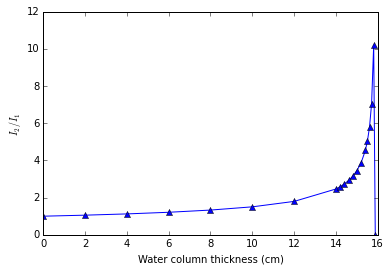

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(water_thickness, table1['Current in IC2'] / table1['Current in IC1'], 'b-^')
plt.ylabel(r'${I_2}/{I_1}$')
plt.xlabel('Water column thickness (cm)')
#plt.savefig('ne551_midterm_1_1c', dpi=300)
plt.show()

## Part 1d ##

Now assume no nuclear interactions occur in the IC's, but that nuclear interactions do occur in the water column. If a nuclear interaction occurs, assume that the proton is lost and doesn't make it out of the water column

## Part 1e ##

Using the assumptions in part d, fill out a table like the one below using the same water column increments you used in part a

In [16]:
table2 = pd.DataFrame(index=water_thickness)

In [17]:
table2['Beam energy after exit from IC1'] = table1['Beam energy after exit from IC1']
table2['Energy deposited in IC1'] = table1['Energy deposited in IC1']
table2['Current in IC1'] = table1['Current in IC1']
table2['Beam energy after exit from water column'] = table1['Beam energy after exit from water column']
table2['Fraction of beam remaining after exit from water column'] =\
        1-nuclear_fraction(1., materials['Water'], water_thickness)
table2['Beam energy after exit from IC2'] = table1['Beam energy after exit from IC2']
table2['Energy deposited in IC2'] = table1['Energy deposited in IC2']
table2['Current in IC2'] = current(
    table2['Energy deposited in IC2'],
    flux*table2['Fraction of beam remaining after exit from water column'],
    diameter
)
table2.to_csv('ne551_midterm_1_1e.csv')

## Part 1f ##

Clearly state your methodology, values for constants, and any equations you used to determine the values in column 6

When considering nuclear interactions, I have approximated the cross sections using the geometric cross section:
    $$\sigma \approx \pi \left( R_1 + R_2 \right)^2$$ where $R_i = r_0 A_i^{1/3}$ and $r_0={1.4 \times 10^{-13}}cm$. Since the energy captured in the second ion chamber is porportional to the number of incident protons, we must multiply the energy deposited in the second ion chamber (in part 1a) by $(1-f)$, where $f$ is the fraction of the protons undergoing a nuclear interaction.

## Part 1g ##

Now plot the values of IC2/IC1 from this table on the same plot you made for part c

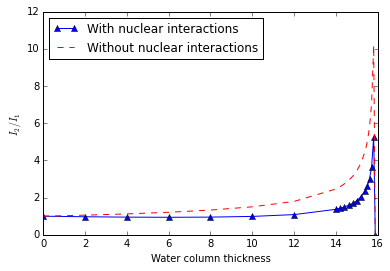

In [18]:
plt.plot(water_thickness, table2['Current in IC2'] / table2['Current in IC1'], 'b-^', label='With nuclear interactions')
plt.plot(water_thickness, table1['Current in IC2'] / table1['Current in IC1'], 'r--', label='Without nuclear interactions')
plt.xlabel('Water column thickness')
plt.ylabel(r'$I_2 / I_1$')
plt.legend(loc=2)
#plt.savefig('ne551_midterm_1_1g', dpi=300)
plt.show()

# Problem 2 #

According to [Vaughan & Asbury's General Ophthalmology](http://accessmedicine.mhmedical.com/content.aspx?sectionid=40229318&bookid=387&jumpsectionID=40229430&Resultclick=2), the diameter of the adult human eye is about 2.4 cm and its mass is about 7.5 g. Assume that the eye is comprised of Adipose Tissue

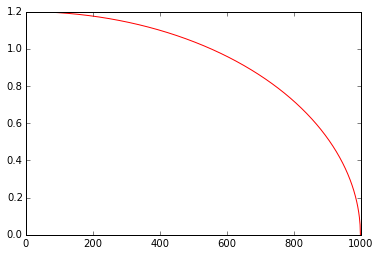

In [19]:
r = 1.2 # cm
x = np.linspace(0, r, 1000)
plt.plot(np.sqrt(r**2 - x**2), 'r-')
plt.show()

From [wolframalpha.com](http://www.wolframalpha.com/input/?i=a+sphere) we know that the average thickness of a sphere is $\frac{4r}{3}$. Therefore the energy received is $\Phi \pi \left( \frac{d}{2} \right)^2 \int_0^{\frac{4 r}{3}} S_c(t) dt$

In [20]:
E_absorbed = 10 ** 5 * np.pi * r ** 2 * energy_deposition(2., materials["Tissue"], 200., 4., 4*r/3.) # MeV
E_absorbed

42210712.22902102

To be more accurate, however, we will instead divide the eye into a series of $n$ annuli with inner radius $r_i$ and outer radius $r_i + \Delta r$. We will approximate the height of these annuli as $2*\frac{f(r_i+\Delta r)+f(r_i)}{2} = f(r_i+\Delta r) + f(r_i)$, where $f(r) = \sqrt{R^2-r^2}$. The surface area of the annuli exposed to the fluence will be $A=\pi \left[\left(r_i+\Delta r\right)^2 - {r_i}^2 \right] = \pi \left(2 r_i \Delta r + \Delta r^2 \right)$. The absorbed dose then becomes: $$ \sum_i \Phi \pi \left(2 r_i \Delta r + \Delta r^2 \right) E_d(f(r_i+\Delta r) + f(r_i))$$

In [49]:
phi = 10**4
delta = 0.01 # cm
def f(x):
    return np.sqrt(r**2 - x**2)
x = np.arange(0, r, delta)
t = np.array([f(i) + f(i + delta) for i in x][:-1]) # annulus thickness
def A(x):
    return np.pi * (x + delta)**2 - np.pi * (x)**2
a = A(x)[:-1]
assert len(t) == len(a)
a = phi * a # multiply fluence by area to get number of particles
e = np.array([energy_deposition(2., materials["Tissue"], T=200, thickness=b, M_b=4.) for b in t])
E_absorbed = np.sum(a * e)
print E_absorbed

4644834.5943


It turns out that this number converges at approximately $\Delta r = 0.01cm$--smaller intervals no longer produce worthwhile gains in accuracy. At this point the disagreement between this method and simply using the average thickness is about 10%

## Part 2a ##

What is the dose (Gy) received by the eye?

In [50]:
joules_per_ev = const.value('electron volt-joule relationship')
print "{0} j per eV".format(joules_per_ev)
ev_per_mev = 10**6
g_per_kg = 10**3
d = E_absorbed * ev_per_mev * g_per_kg * joules_per_ev / ((4./3. * np.pi * r**2) * materials["Tissue"].density)
print "Dose received is {0} Gy".format(d)

1.6021766208e-19 j per eV
Dose received is 0.000134103994594 Gy


## Part 2b ##

What is the equivalent dose ($H_T$ in Sv) received by the eye?

$$ H_T = Q \times D $$ According to [ICRP publication 103](http://www.icrp.org/publication.asp?id=ICRP%20Publication%20103), pg. 58, the Q factor for $\alpha$ particles is 20

In [51]:
q = 20
h_t = q * d
print "Effective dose is {0} Sv".format(h_t)

Effective dose is 0.00268207989188 Sv


## Part 2c ##

What is the contribution to the effective dose (E in Sv) received by the eye?

According to Anderson Table 14.2, there is no specific weighting factor assigned to the eye. There is a general $w_T$ assigned to all other portions of the body not covered by another weighting factor of 0.05. Therefore, the effective dose received by the eye in part 2b should have the same stochastic effects as a dose of $$H_T \times w_t = 1.16 Sv \times 0.05 $$

It is worth noting that this does not account for the specific deterministic effects to the eye, which may be much more severe.

In [54]:
whole_body_equivalent_dose = h_t*0.05
print "Whole body equivalent dose is {0} Sv".format(whole_body_equivalent_dose)

Whole body equivalent dose is 0.000134103994594 Sv


# Problem 3 #

Calculate the mass stopping powers for electrons and positrons in tungsten (Z=74, A=184) for the following energies: 1 keV, 10 keV, 20 keV, 50 keV, 100 keV, 200 keV, 500 keV, 1 MeV, 2 MeV. Use the equations given in class. Make a plot of the mass stopping power versus the energies given above for both electrons and positrons, and include the NIST values for electron mass stopping powers in tungsten in that plot.

The stopping power for an electron is described by Rohrlich and Carlson as: 
$$ \left(-\frac{dE}{ds}\right) = N Z \chi \left[\ln\left(\frac{T^2}{I^2} \frac{\gamma + 1}{2}\right) + f^{\pm}(\gamma)\right],$$ where $$N=\frac{N_A Z \rho}{M_m},$$ $$\chi = \frac{2 \pi r_0^2 m_e c^2}{\beta^2},$$ $$f^+(\gamma) = 2 \ln{2} - \frac{\beta^2}{12} \left[23 + \frac{14}{\gamma+1} + \frac{10}{{(\gamma+1)}^2} + \frac{4}{{(\gamma+1)}^3}\right],$$ and $$ f^-(\gamma) = 1 - \beta^2 - \frac{2 \gamma - 1}{\gamma^2}\ln{2} + \frac{1}{8}{\left( \frac{\gamma - 1}{\gamma}\right) }^2$$

For electrons, we use the $f^-$ equation; for positrons we use the $f^+$ equation.

In [55]:
N_A = const.Avogadro
print "Avogadro's number: {0}".format(N_A)
r_0 = const.value('classical electron radius') * 100. # convert to cm
print "Classical electron radius: {0} cm".format(r_0)
m_e = const.value('electron mass energy equivalent in MeV')
print "Electron mass: {0}".format(m_e)
Z = 74.
A = 184.
I = 727 * 10**-6 # MeV, from http://physics.nist.gov/cgi-bin/Star/compos.pl?matno=074
rho = 19.3 # g/cm^3, from http://physics.nist.gov/cgi-bin/Star/compos.pl?matno=074
T = np.array([1., 10., 20., 50., 100., 200., 500., 1000., 2000.]) / 1000. # convert to MeV

Avogadro's number: 6.022140857e+23
Classical electron radius: 2.8179403227e-13 cm
Electron mass: 0.5109989461


In [56]:
# utility functions to calculate gamma^2 and beta^2 given a mass and a kinetic energy
from stoppingpower.utility import beta_2, gamma_2

In [27]:
def F_plus(T):
    g_2 = gamma_2(m=m_e, T=T)
    g = g_2 ** 0.5
    b_2 = beta_2(m=m_e, T=T)    

    first = 23.
    second = 14. / (g + 1.)
    third = 10. / (g + 1.)**2
    fourth = 4. / (g + 1)**3
    
    f = 2. * np.log(2.) - (b_2 / 12.) * (first + second + third + fourth)
    
    return f

def F_minus(T):
    g_2 = gamma_2(m=m_e, T=T)
    g = g_2 ** 0.5
    b_2 = beta_2(m=m_e, T=T)
    tau = T / m_e
    
    f = 1. - b_2 - (1. / g_2) * (2. * g - 1.) * np.log(2.) + (1. / 8) * ((g - 1) / g) ** 2
    
    return f
 
def electron_stopping_power(T, I, plus=True):
    g = gamma_2(m=m_e, T=T) ** (0.5)
    b_2 = beta_2(m=m_e, T=T)
    
    if plus:
        f = F_plus(T)
    else:
        f = F_minus(T)
    
    X = 2 * np.pi * r_0**2 * m_e / b_2
        
    first = N_A * Z * X / A
    logpart = (T**2 * (g + 1.)) / (I**2 * 2)
    
    return first * (np.log(logpart) + f)

In [28]:
result = pd.DataFrame(index=T)

In [29]:
estar_results = np.array([14.91, 8.974, 5.753, 3.137, 2.047, 1.439, 1.085, 1.016, 1.037])

In [30]:
result['Electron stopping power'] = electron_stopping_power(T, I, plus=False)
result['Positron stopping power'] = electron_stopping_power(T, I, plus=True)
result['eStar reference values'] = estar_results
result['error'] =\
        (result['Electron stopping power'] - result['eStar reference values']) / result['eStar reference values']
result

,Electron stopping power,Positron stopping power,eStar reference values,error
0.001,14.898861,31.870934,14.910,-0.000747
0.010,8.968007,10.613291,8.974,-0.000668
0.020,5.750050,6.544161,5.753,-0.000513
0.050,3.137116,3.421265,3.137,0.000037
0.100,2.048300,2.163544,2.047,0.000635
0.200,1.443405,1.475774,1.439,0.003061
0.500,1.097048,1.082607,1.085,0.011104
1.000,1.039923,1.011772,1.016,0.023546
2.000,1.081613,1.047357,1.037,0.043021


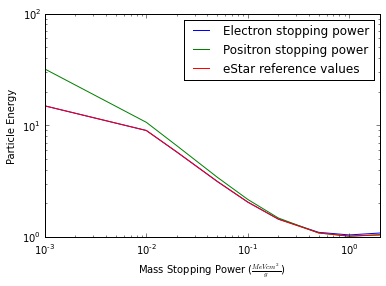

In [31]:
ax = result.ix[:, result.columns.difference(['error'])].plot(loglog=True)
ax.set_xlabel(r'Mass Stopping Power ($\frac{MeV cm^2}{g}$)')
ax.set_ylabel('Particle Energy')

As can be seen in the error column above, this equation holds very well when energies are low, but as kinetic energy approaches rest mass energy it begins to diverge from reality (as reported by eStar) due to relativistic effects.

# Problem 4 #

Starting with the Klein-Nishina equation, calculate the mass attenuation coefficient for Compton scattering of 1 keV, 10 keV, 100 keV, 200 keV, 500 keV, 1 MeV, and 2 MeV photons on carbon, aluminum, and lead. Compare your values with the appropriate values found in the NIST XCOM tables.

In [32]:
E = np.array([1., 10., 100., 200., 500., 1000., 2000.]) / 1000. # MeV
xstar_carbon = np.array([1.263e-2, 1.352e-1, 1.466e-1, 1.219e-1, 8.699e-2, 6.358e-2, 4.410e-2])
xstar_aluminum = np.array([1.427e-2, 1.058e-1, 1.388e-1, 1.168e-1, 8.374e-2, 6.129e-2, 4.252e-2])
xstar_lead = np.array([3.587e-3, 4.540e-2, 9.894e-2, 8.966e-2, 6.734e-2, 4.993e-2, 3.482e-2])

In [33]:
def klein_nishina(E):
    a = E / m_e # convert from keV to MeV
    
    c = np.pi * r_0**2
    first = ((2. * (1. + a)) / a**2) * (((2. * (1. + a)) / (1. + 2. * a)) - (np.log(1. + 2. * a) / a))
    second = np.log(1. + 2. * a) / a
    third = 2. * (1. + 3. * a) / (1. + 2. * a)**2
    
    result = c * (first + second - third)
    
    return result

def mass_attenuation(E, material):
    return klein_nishina(E) * N_A * material.Z / material.mass

In [34]:
mass_attenuation(E, materials['Carbon, 6'])

array([ 0.19935183,  0.19267773,  0.14823741,  0.12228532,  0.08699218,
        0.06353933,  0.04403033])

In [35]:
results = pd.DataFrame(
    {
        "Carbon": mass_attenuation(E, materials['Carbon, 6']),
        "Aluminum": mass_attenuation(E, materials['Aluminum, 13']),
        "Lead": mass_attenuation(E, materials['Lead, 82'])
    },
    index=E
)
results

,Aluminum,Carbon,Lead
0.001,0.192272,0.199352,0.157916
0.010,0.185835,0.192678,0.152630
0.100,0.142973,0.148237,0.117426
0.200,0.117942,0.122285,0.096868
0.500,0.083903,0.086992,0.068911
1.000,0.061283,0.063539,0.050333
2.000,0.042467,0.044030,0.034879


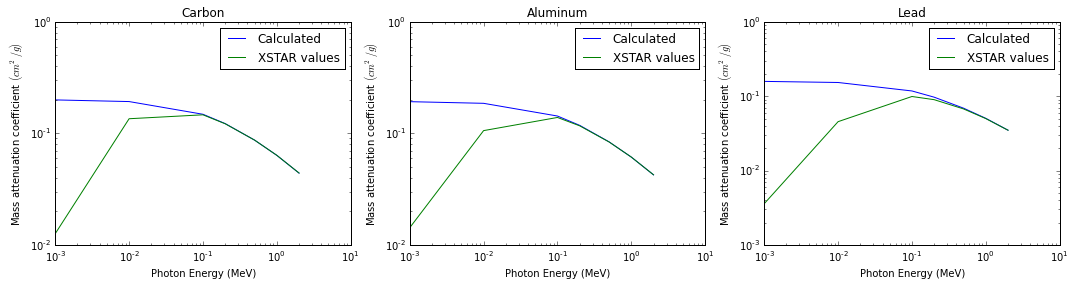

In [36]:
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.plot(E, results["Carbon"], label="Calculated")
plt.plot(E, xstar_carbon, label="XSTAR values")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Photon Energy (MeV)")
plt.ylabel(r'Mass attenuation coefficient $\left(cm^2/g\right)$')
plt.legend(loc='upper right')
plt.title("Carbon")

plt.subplot(132)
plt.plot(E, results["Aluminum"], label="Calculated")
plt.plot(E, xstar_aluminum, label="XSTAR values")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Photon Energy (MeV)")
plt.ylabel(r'Mass attenuation coefficient $\left(cm^2/g\right)$')
plt.legend(loc='upper right')
plt.title("Aluminum")

plt.subplot(133)
plt.plot(E, results["Lead"], label="Calculated")
plt.plot(E, xstar_lead, label="XSTAR values")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Photon Energy (MeV)")
plt.ylabel(r'Mass attenuation coefficient $\left(cm^2/g\right)$')
plt.legend(loc='upper right')
plt.title("Lead")

plt.show()

These values agree at high energies, but diverge at low energies, as expected. the Compton scattering coefficient relates to the Klein-Nishina cross section by $$d \sigma_{IS} = d \sigma_{KN} \times S(h \nu, \theta^\prime, Z) $$ Unfortunately this value has not been calculated and must be determined [experimentally](http://www.sciencedirect.com/science/article/pii/S0969806X97000492).

# Problem 5 #

Using the same energies given in No. 4, calculate the fraction of photons that undergo coherent scattering, photo-electric, Compton scattering and pair production through 2 cm of aluminum. Also calculate the fraction of photon energy absorbed by the Aluminum.

Using the mass attenuation values from [XCOM](http://physics.nist.gov/cgi-bin/Xcom/xcom3_1) for Aluminum

In [37]:
coherent = np.array([2.26E+00, 5.51E-01, 1.32E-02, 3.50E-03, 5.73E-04, 1.44E-04, 3.60E-05])
incoherent = np.array([1.43E-02, 1.06E-01, 1.39E-01, 1.17E-01, 8.37E-02, 6.13E-02, 4.25E-02])
photoelectric = np.array([1.18E+03, 2.56E+01, 1.84E-02, 2.00E-03, 1.34E-04, 2.64E-05, 7.63E-06])
pairproduction = np.array([0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 0.00E+00, 6.75E-04])
total = np.array([1.183E+03, 2.566E+01, 1.572E-01, 1.188E-01, 8.388E-02, 6.132E-02, 4.320E-02])

To determine energy absorbed for these photons, we use the mass attenuation coefficient in Appendix 9

In [38]:
absorption = np.array(
    [52500., 1140., 1.67, 1.22, 1.30, 1.20, 1.01]) * 0.002232 * 100 * 100 / 1000 # Convert from m^2/kg to cm^2/g

In [39]:
t = 2. # cm
mat = materials['Aluminum, 13']
rho = mat.density

The fraction undergoing each type of interaction is  $e^{\frac{\mu}{\rho} \times\rho \times t}$

In [40]:
results = pd.DataFrame(
    {
        "Energy": E,
        "Coherent": 1 - np.exp(-1. * coherent * rho * t),
        "Incoherent": 1 - np.exp(-1. * incoherent * rho * t),
        "Photoelectric": 1 - np.exp(-1. * photoelectric * rho * t),
        "Pair Production": 1 - np.exp(-1. * pairproduction * rho * t),
        "Total": 1 - np.exp(-1. * total * rho * t),
        "Energy fraction deposited": (1 - np.exp(-1. * absorption * rho * t))
    }
)
results.set_index('Energy')
results = results[['Energy', 'Coherent', 'Incoherent', 'Photoelectric', 'Pair Production', 'Energy fraction deposited']]
results

,Energy,Coherent,Incoherent,Photoelectric,Pair Production,Energy fraction deposited
0,0.001,0.999995,0.074285,1.000000,0.000000,1.000000
1,0.010,0.948911,0.435699,1.000000,0.000000,1.000000
2,0.100,0.068772,0.527772,0.094547,0.000000,0.182251
3,0.200,0.018715,0.468229,0.010738,0.000000,0.136692
4,0.500,0.003088,0.363516,0.000723,0.000000,0.144973
5,1.000,0.000777,0.281712,0.000142,0.000000,0.134610
6,2.000,0.000194,0.204995,0.000041,0.003637,0.114572


# Problem 6 #

$^{229}$Th decays into $^{225}$Ra, which then decays into $^{225}$Ac and $^{213}$Bi, two isotopes important for "targeted alpha therapy" (TAT), a medical technique used to kill tumors. The supply of $^{229}$Th has traditionally come from the stockpile of $^{233}$U (which alpha decays into $^{229}$Th). The amount of $^{229}$Th generated this way is very limited, so alternate methods of production are being explored. One method is to bombard a $^{232}$Th target with energetic protons that then produce $^{229}$Th through the following reactions:

1.  $^{232}$Th(p,nt)$^{229}$Th
2.  $^{232}$Th(p,2nd)$^{229}$Th
3.  $^{232}$Th(p,3np)$^{229}$Th

Calculate the proton threshold kinetic energy (in MeV) required for these three reactions. Show your method for calculating these threshold energies.

Mass excess values are obtained from Anderson Appendix 5

In [41]:
# Mass energy equivalence, MeV/amu
mev_per_amu = const.value('atomic mass constant energy equivalent in MeV')
print "{0} MeV/amu".format(mev_per_amu)

931.4940954 MeV/amu


In [42]:
# values are in keV
mass_excess = { # from Anderson Appendix 5
    "proton": 7288.99,
    "neutron": 8071.44,
    "deuteron": 13135.91,
    "triton": 14949.95,
    "229Th": 29483.,
    "232Th": 35512.
}
mass = { 
    "proton": 938.272046, # from NIST CODATA
    "neutron": 939.56541, # from NIST CODATA
    "deuteron": 1875.612928, # from NIST CODATA
    "triton": 2808.921112, # from NIST CODATA
    "229Th": 229.031762 * mev_per_amu, # Wikipedia
    "232Th": 232.0380553 * mev_per_amu # Wikipedia
}

In [43]:
def q(parent_delta_e_list, daughter_delta_e_list):
    parent_q = sum([mass_excess.get(p) for p in parent_delta_e_list])
    daughter_q = sum([mass_excess.get(d) for d in daughter_delta_e_list])
    
    return parent_q - daughter_q

In [44]:
# threshold energy is in keV
def threshold_energy(parent_list, daughter_list):
    Q = abs(min([q(parent_list, daughter_list), 0]))
    
    if Q == 0:
        return 0.
    else:
        numerator = Q
        denominator = 1. - mass.get("proton") / (sum([mass.get(i) for i in daughter_list]))
        return numerator / denominator

$^{232}$Th(p,nt)$^{229}$Th

In [45]:
threshold_energy(["232Th", "proton"], ["229Th", "neutron", "triton"])

9745.520503825881

$^{232}$Th(p,2nd)$^{229}$Th

In [46]:
threshold_energy(["232Th", "proton"], ["229Th", "neutron", "neutron", "deuteron"])

16030.080610587012

$^{232}$Th(p,3np)$^{229}$Th

In [47]:
threshold_energy(["232Th", "proton"], ["229Th", "neutron", "neutron", "neutron", "proton"])

18264.255711723028